In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, date

import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.plotting import autocorrelation_plot

import statsmodels.graphics.tsaplots as tsg
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [2]:
df_raw = pd.read_csv('./data/00_original/Lake_Bilancino.csv', sep=',', header=0)

df = df_raw[['Date', 'Lake_Level']].copy()
df['Date'] = pd.to_datetime(df['Date'], format = '%d/%m/%Y')

df.set_index(['Date'], inplace=True)
df = df.asfreq('D')
print(df.index)

# df = df.resample('W').mean()
# df = df.asfreq('W')
df.head(5)

DatetimeIndex(['2002-06-03', '2002-06-04', '2002-06-05', '2002-06-06',
               '2002-06-07', '2002-06-08', '2002-06-09', '2002-06-10',
               '2002-06-11', '2002-06-12',
               ...
               '2020-06-21', '2020-06-22', '2020-06-23', '2020-06-24',
               '2020-06-25', '2020-06-26', '2020-06-27', '2020-06-28',
               '2020-06-29', '2020-06-30'],
              dtype='datetime64[ns]', name='Date', length=6603, freq='D')


,Lake_Level
Date,
2002-06-03,249.43
2002-06-04,249.43
2002-06-05,249.43
2002-06-06,249.43
2002-06-07,249.44


In [3]:
df['Lake_Level'] -= (251 - 31)
print(df.isna().sum())

Lake_Level    0
dtype: int64


<AxesSubplot:xlabel='Date'>

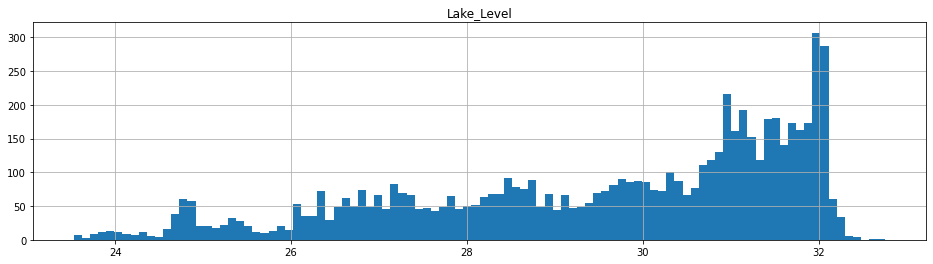

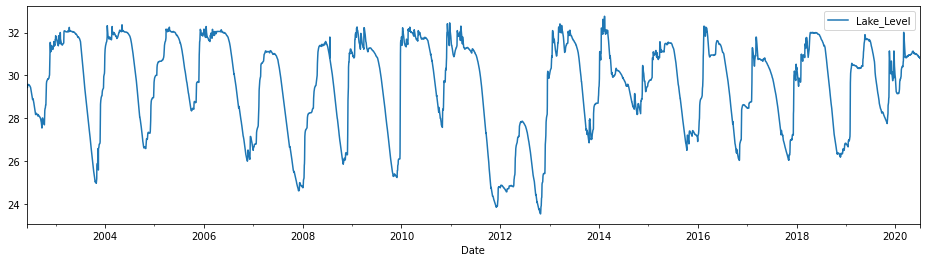

In [4]:
df.hist(figsize=(16, 4), bins=100)
df.plot(figsize=(16, 4))

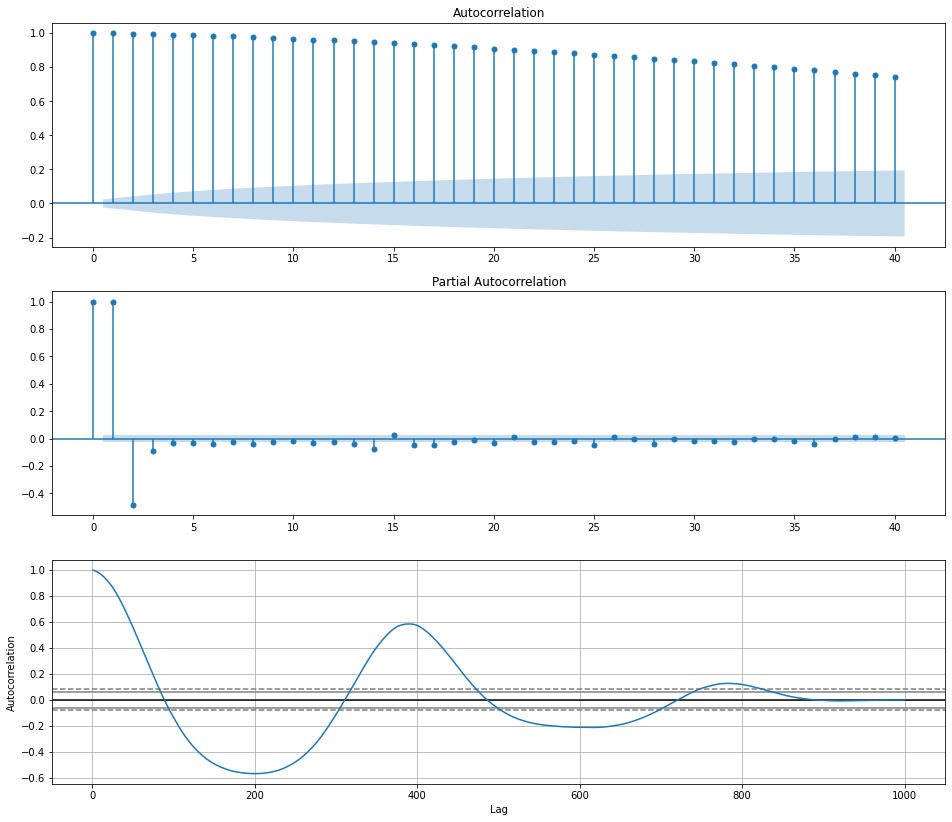

In [5]:
# SEASONALITY CHECK
from pandas.plotting import autocorrelation_plot

fig, ax = plt.subplots(3, 1, figsize=(16, 14))

tsg.plot_acf(df['Lake_Level'],lags=40, ax=ax[0])
tsg.plot_pacf(df['Lake_Level'],lags=40, ax=ax[1])
autocorrelation_plot(df['Lake_Level'][:1000], ax=ax[2])

plt.show()

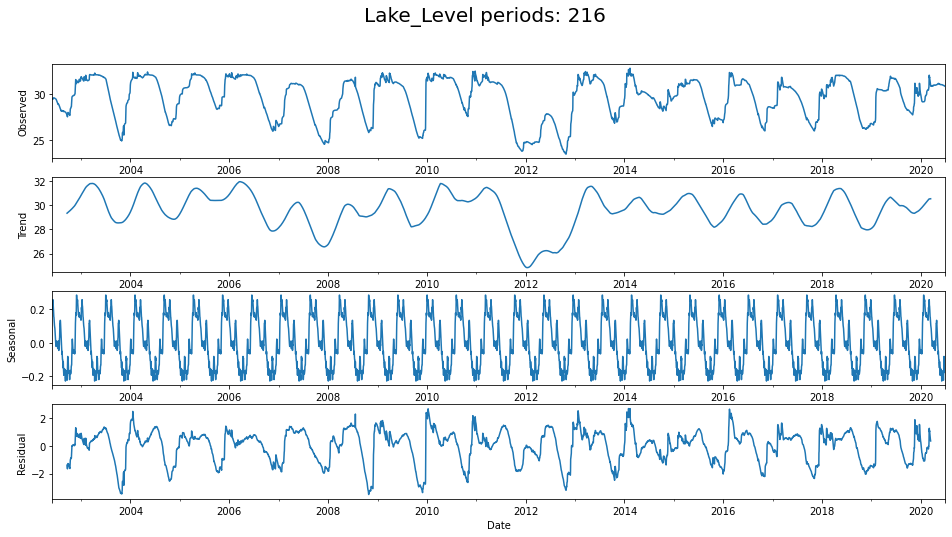

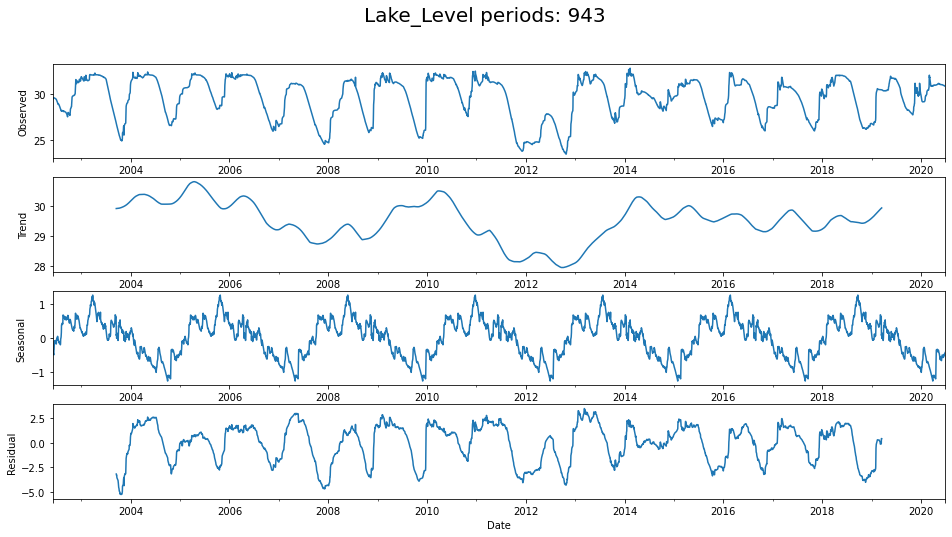

In [6]:
months = int(((max(df.index) - min(df.index))/np.timedelta64(1, 'M')))
weeks = int(((max(df.index) - min(df.index))/np.timedelta64(1, 'W')))

def seasonal_decompose_plot(series, period):
    
    result = seasonal_decompose(series, model='additive', period=period)

    fig, ax = plt.subplots(4,1, figsize=(16, 8))
    
    fig.suptitle('{} periods: {}'.format(series.name, period), size=20)

    result.observed.plot(ax=ax[0])
    ax[0].set_ylabel('Observed')
    result.trend.plot(ax=ax[1])
    ax[1].set_ylabel('Trend')
    result.seasonal.plot(ax=ax[2])
    ax[2].set_ylabel('Seasonal')
    result.resid.plot(ax=ax[3])
    ax[3].set_ylabel('Residual')
    
seasonal_decompose_plot(df['Lake_Level'], months)
seasonal_decompose_plot(df['Lake_Level'], weeks)

Dickey-Fuller Test for "Lake_Level":
	 ADF = -6.880991194599921
	   p = 1.4336336890483035e-09
	data IS stationary => p < 0.05 & adf < 1%


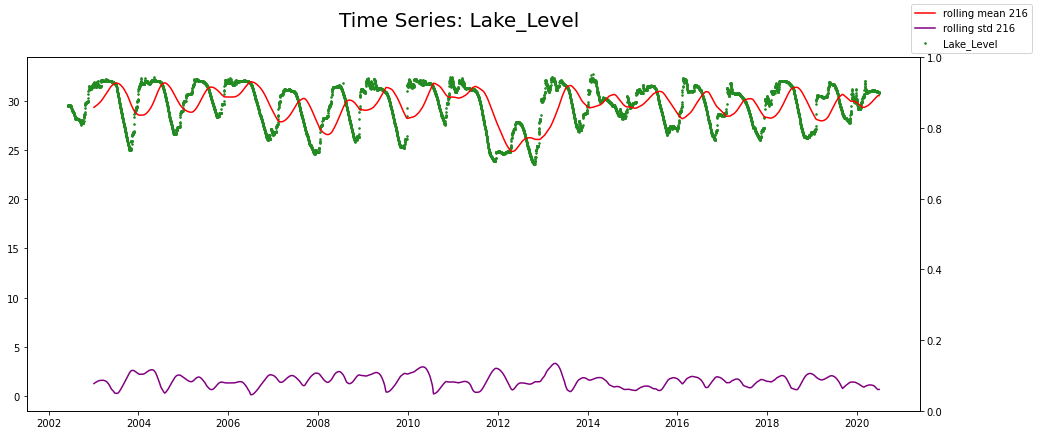

In [7]:
# STATIONARITY
# Stationarity check means that we have constant mean and variance of the data over the time.
# We can inspect visually or use Dickey-Fuller statistical test.

# Dickey-Fuller statisticall test:
# Is trying to reject the null hypothesis that the data is non-stationary.
# If we reject the test means that data is stationary
#    if p <= 0.05 we reject the null hypothesis and data is stationary
#    if p >  0.05 we accept the null hypothesis and data is non-stationary

def testDickeyFuller(series, rolling_interval):
    adf_test_result = sts.adfuller(series.values)
    
    significance_level = 0.05
    adf = adf_test_result[0]
    pValue = adf_test_result[1]
    threshold_1 = adf_test_result[4]['1%']
    threshold_5 = adf_test_result[4]['5%']
    threshold_10 = adf_test_result[4]['10%']
    
    print('Dickey-Fuller Test for "{}":'.format(series.name))
    print('\t ADF = {}'.format(str(adf)))
    print('\t   p = {}'.format(str(pValue)))
    
    color = 'purple'
    if (pValue < significance_level) & (adf < threshold_1):
        color = 'forestgreen' 
        print('\tdata IS stationary => p < {} & adf < 1%'.format(significance_level))
    elif (pValue < significance_level) & (adf < threshold_5):
        color = 'orange'
        print('\tdata IS stationary => p < {} & adf < 5%'.format(significance_level))
    elif (pValue < significance_level) & (adf < threshold_10):
        color = 'red'
        print('\tdata IS stationary => p < {} & adf < 10%'.format(significance_level))
    else:
        print('\tdata NOT stationary')
        
    fig, ax = plt.subplots(1, 1, figsize=(16, 6.5))
    
    fig.suptitle('Time Series: {}'.format(series.name), size=20)
    
    ax.scatter(x=df.index, y=series, color=color, label=series.name, marker='.', s=10, alpha=1)
    ax2 = ax.twinx()

    ax.plot(series.rolling(rolling_interval).mean(), color='red', label='rolling mean {}'.format(rolling_interval))
    ax.plot(series.rolling(rolling_interval).std(), color='purple', label='rolling std {}'.format(rolling_interval))
    fig.legend()

testDickeyFuller(df['Lake_Level'], months)

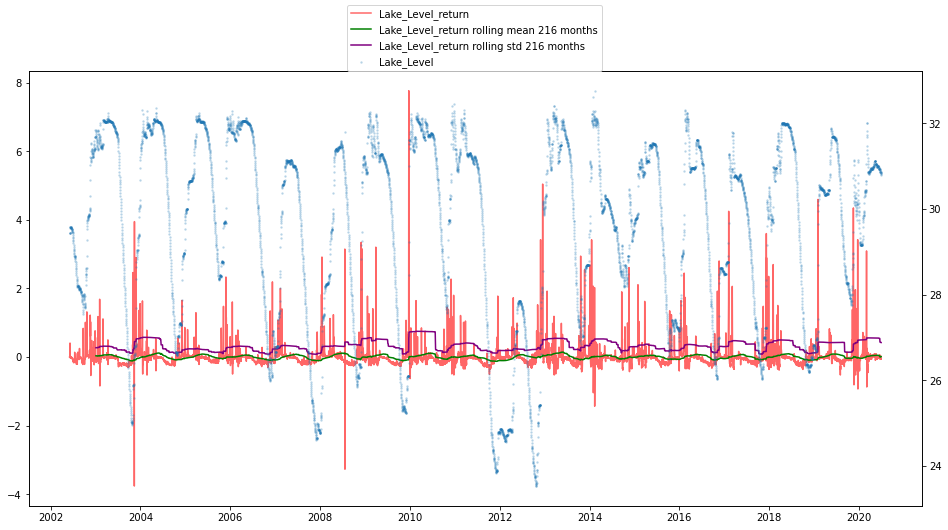

In [8]:
# Lake Level is stationary and this step is not needed

df['Lake_Level_return'] = df['Lake_Level'].pct_change(1).mul(100)
# df['Lake_Level_return'] = df['Lake_Level'].diff()
df = df.dropna()

fig, ax = plt.subplots(1, 1, figsize=(16, 8))
ax.plot(df['Lake_Level_return'], color='red', alpha=0.6, label='Lake_Level_return')
ax.plot(df['Lake_Level_return'].rolling(months).mean(), color='green', label='Lake_Level_return rolling mean {} months'.format(months))
ax.plot(df['Lake_Level_return'].rolling(months).std(), color='purple', label='Lake_Level_return rolling std {} months'.format(months))

ax2 = ax.twinx()
ax2.scatter(x=df.index, y=df['Lake_Level'], label='Lake_Level', marker='.', s=10, alpha=0.2)

fig.legend(loc='upper center')

Dickey-Fuller Test for "Lake_Level_return":
	 ADF = -11.342444963765292
	   p = 1.0465264217696878e-20
	data IS stationary => p < 0.05 & adf < 1%


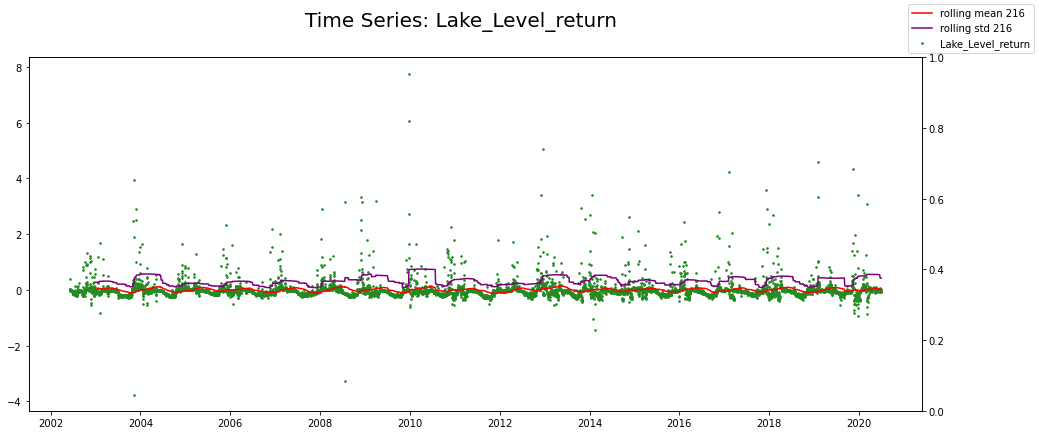

In [9]:
# Translating Lake_Level to % changes as expected did not change stationarity property

testDickeyFuller(df['Lake_Level_return'], months)

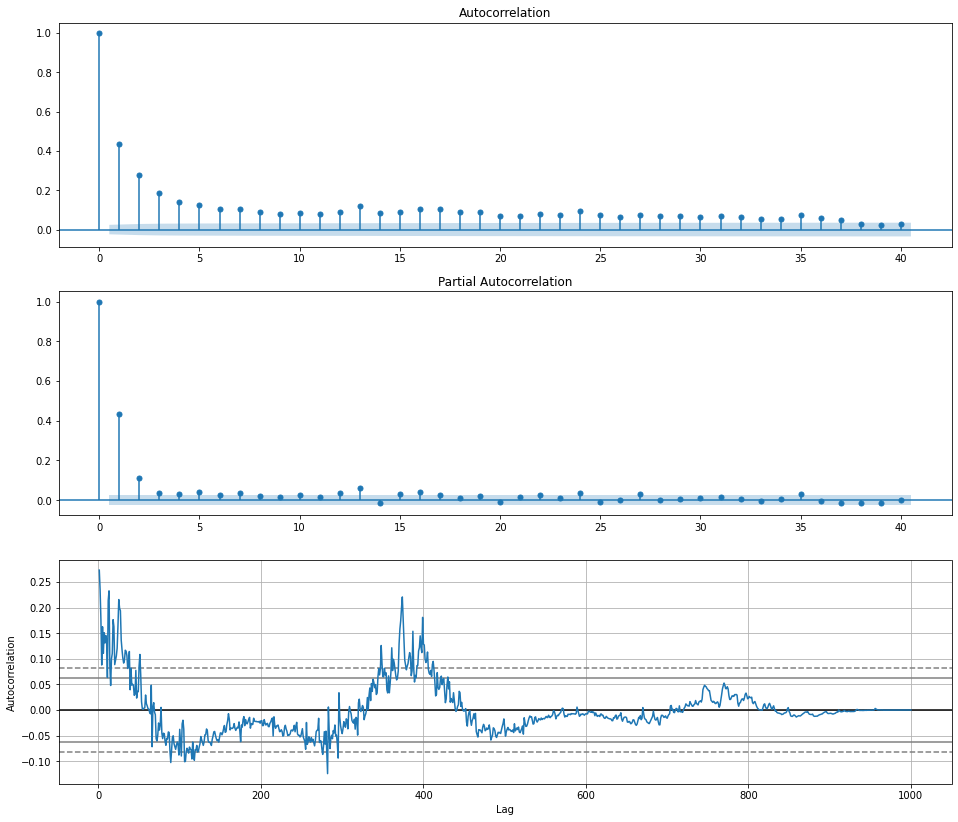

In [10]:
fig, ax = plt.subplots(3, 1, figsize=(16, 14))

tsg.plot_acf(df['Lake_Level_return'],lags=40, ax=ax[0])
tsg.plot_pacf(df['Lake_Level_return'],lags=40, ax=ax[1])
autocorrelation_plot(df['Lake_Level_return'][:1000], ax=ax[2])

plt.show()

            Lake_Level  Lake_Level_return
Date                                     
2016-11-13       26.94           0.111483
2016-11-14       26.96           0.074239
2016-11-15       26.98           0.074184
2016-11-16       26.98           0.000000
2016-11-17       26.99           0.037064
            Lake_Level  Lake_Level_return
Date                                     
2016-11-18       27.00           0.037051
2016-11-19       27.50           1.851852
2016-11-20       28.27           2.800000
2016-11-21       28.39           0.424478
2016-11-22       28.45           0.211342


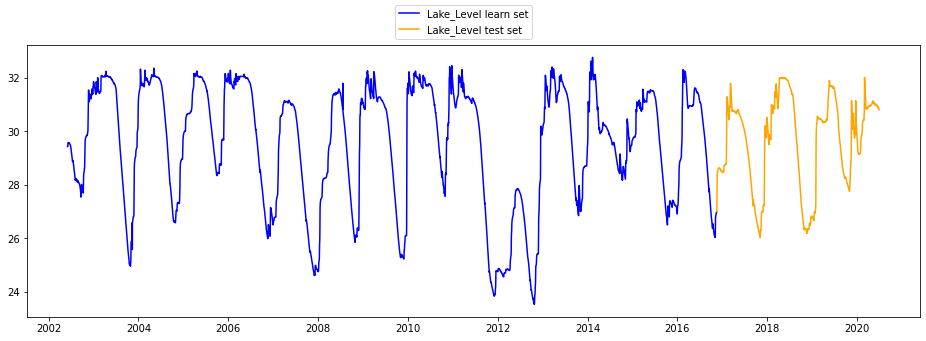

In [11]:
test_percentage = 0.2

split = int(len(df) * (1 - test_percentage))
df_learn = df.iloc[:split]
df_test = df.iloc[split:]

fig, ax = plt.subplots(1, 1, figsize=(16, 5))

ax.plot(df_learn['Lake_Level'], color='blue', label='Lake_Level learn set')
ax.plot(df_test['Lake_Level'], color='orange', label='Lake_Level test set')
fig.legend(loc='upper center');

print(df_learn.tail(5))
print(df_test.head(5))

                               SARIMAX Results                                
Dep. Variable:             Lake_Level   No. Observations:                 5281
Model:               SARIMAX(2, 0, 2)   Log Likelihood                5175.484
Date:                Tue, 09 Feb 2021   AIC                         -10340.967
Time:                        18:11:00   BIC                         -10308.108
Sample:                    06-04-2002   HQIC                        -10329.482
                         - 11-17-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.8059      0.013    140.600      0.000       1.781       1.831
ar.L2         -0.8059      0.013    -62.728      0.000      -0.831      -0.781
ma.L1         -0.4626      0.013    -36.068      0.0

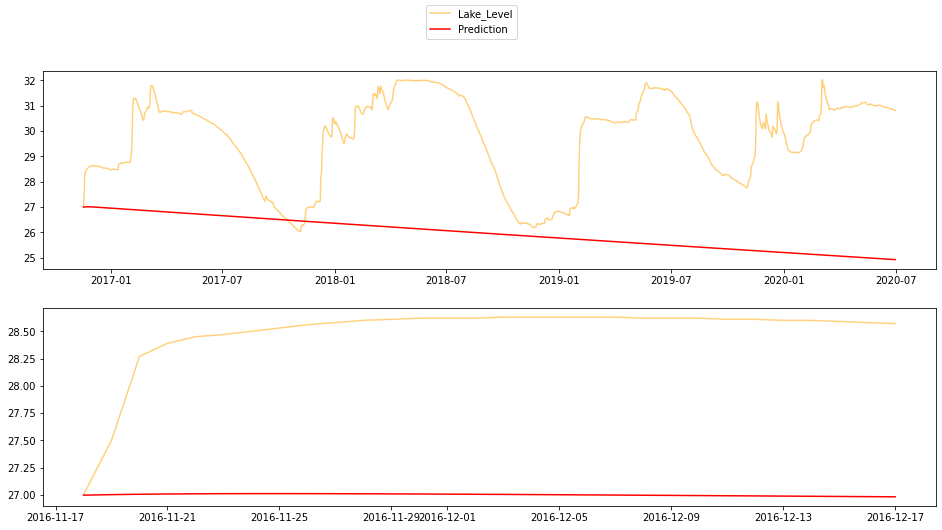

In [12]:
learn = df_learn['Lake_Level']
test = df_test['Lake_Level']

model = SARIMAX(learn, order=(2, 0, 2), season=(0, 0, 0, 0))
        
model_fit = model.fit()
print(model_fit.summary())

predictions = model_fit.predict(start=test.index[0], end=test.index[-1])
print(predictions.head(10))

fig, ax = plt.subplots(2, 1, figsize=(16, 8))
ax[0].plot(test, color='orange', label=test.name, alpha=0.5)
ax[0].plot(predictions, color='red', label='Prediction')
fig.legend(loc='upper center');

ax[1].plot(test[0:30], color='orange', label=test.name, alpha=0.5)
ax[1].plot(predictions[0:30], color='red', label='Prediction')